In [1]:
import cv2
import os
import shutil
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)
# Tentukan direktori tujuan untuk memindahkan dataset
new_directory = '/content/plant-disease-dataset'

# Memindahkan dataset ke direktori baru
shutil.move(path, new_directory)

100%|██████████| 1.25G/1.25G [00:06<00:00, 217MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/versions/1


'/content/plant-disease-dataset'

In [3]:
print(os.getcwd())

/content


In [4]:
TRAIN_DIR = 'plant-disease-dataset/Train/Train'
TEST_DIR = 'plant-disease-dataset/Test/Test'
VAL_DIR = 'plant-disease-dataset/Validation/Validation'


In [5]:
# Directory with the training horse pictures
train_powdery_dir = os.path.join(TRAIN_DIR, 'Powdery')
train_healthy_dir = os.path.join(TRAIN_DIR, 'Healthy')
train_rust_dir = os.path.join(TRAIN_DIR, 'Rust')


# Check the filenames
train_powdery_names = os.listdir(train_powdery_dir)
print(f"5 files in Powdery subdir: {train_powdery_names[:5]}")
train_healthy_names = os.listdir(train_healthy_dir)
print(f"5 files in Not Powdery subdir:{train_healthy_names[:5]}")
train_rust_names = os.listdir(train_rust_dir)
print(f"5 files in Not Powdery subdir:{train_rust_names[:5]}")

5 files in Powdery subdir: ['ddca2303c383d9b9.jpg', '95cb3b9998371299.jpg', 'ddd22d3896cac585.jpg', 'e160ddea201fe29d.jpg', '8f0d749f8cc01b3e.jpg']
5 files in Not Powdery subdir:['80eb96948bd68f9a.jpg', '97a58fc648ae9878.jpg', '9f9c55656a4592b2.jpg', '91ec138593c7d1ba.jpg', '9e21c4da3336bd52.jpg']
5 files in Not Powdery subdir:['a6f2d98bb4a42d25.jpg', '9fe9c28c28730e9e.jpg', 'a4e689347133f98e.jpg', 'c1cc8f836c9239eb.jpg', 'ace8591d545f5683.jpg']


In [6]:
# # Data augmentation dan normalisasi
# train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
#                                    width_shift_range=0.2, height_shift_range=0.2,
#                                    horizontal_flip=True)
# valid_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# Load data dari folder
# Instantiate the dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
    )

valid_data = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
    )

test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


In [7]:
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)

In [8]:
# Rescale the image using a lambda function
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
valid_dataset_scaled = valid_data.map(lambda image, label: (rescale_layer(image), label))
test_dataset_scaled = test_data.map(lambda image, label: (rescale_layer(image), label))


In [11]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([
    # Specify the input shape.
    tf.keras.Input(shape=(150,150,3)),
    # Add the augmentation layers
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomShear(0.2),
    ])

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'RandomShear'

In [ ]:
model = models.Sequential([
    data_augmentation,
    tf.keras.Input(shape=(150, 150, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')  # Gunakan 'softmax' untuk multi-kelas
])

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',  # Gunakan 'categorical_crossentropy' untuk multi-kelas
              metrics=['accuracy'])

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )
validation_dataset_final = (test_dataset_scaled
                       .cache()
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

In [ ]:
# Remember to inherit from the correct class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.8 and validation accuracy is greater or equal to 0.8
        if logs.get('loss', 0) <= 0.15 and logs.get('val_loss', 0) <= 0.18:
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [ ]:
history = model.fit(
    train_dataset_scaled,
    epochs=50,  # Ubah sesuai kebutuhan
    validation_data=validation_dataset_final,
    verbose = 2,
    callbacks=[EarlyStoppingCallback()]
)

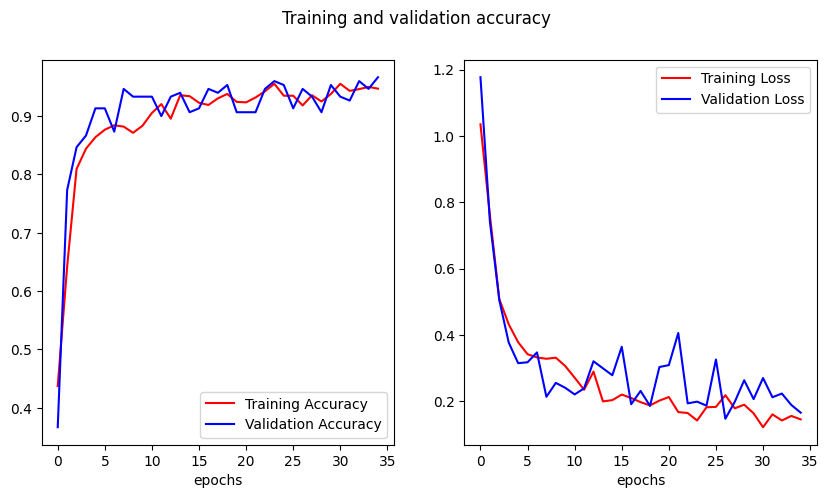

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(valid_dataset_scaled)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

2/2 [==============================] - 0s 14ms/step - loss: 0.1683 - accuracy: 0.9500
Test Accuracy: 95.00%
